In [7]:
import pandas as pd
import urllib.request
import numpy as np
from IPython.display import display

In [8]:
print('Loading merged data ...')
mutations = pd.read_csv("pancancer_mutations_merged.csv")
print("done.")
print("Mutations count", mutations.Tumor_Sample_Barcode.count())

Loading merged data ...


/Users/vijay/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,13,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done.
Mutations count 3570876


In [9]:
mutations.head()

,Unnamed: 0,Hugo_Symbol,Chromosome,Variant_Classification,Variant_Type,Tumor_Sample_Barcode,CENTERS,row,cancer_type,bcr_patient_barcode,bcr_patient_uuid,gender,vital_status,days_to_birth,days_to_death,age_at_initial_pathologic_diagnosis,pathologic_stage,height,weight
0,0,TACC2,10,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS,0,GBM,TCGA-02-0003,df3c1d61-79c1-43e9-971a-8029497ffeab,MALE,Dead,-18341,144.0,50,NaN,NaN,NaN
1,1,JAKMIP3,10,Silent,SNP,TCGA-02-0003-01A-01D-1490-08,MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS,1,GBM,TCGA-02-0003,df3c1d61-79c1-43e9-971a-8029497ffeab,MALE,Dead,-18341,144.0,50,NaN,NaN,NaN
2,2,PANX3,11,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS,2,GBM,TCGA-02-0003,df3c1d61-79c1-43e9-971a-8029497ffeab,MALE,Dead,-18341,144.0,50,NaN,NaN,NaN
3,3,SPI1,11,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,RADIA|MUSE,3,GBM,TCGA-02-0003,df3c1d61-79c1-43e9-971a-8029497ffeab,MALE,Dead,-18341,144.0,50,NaN,NaN,NaN
4,4,NAALAD2,11,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS,4,GBM,TCGA-02-0003,df3c1d61-79c1-43e9-971a-8029497ffeab,MALE,Dead,-18341,144.0,50,NaN,NaN,NaN


In [10]:
mutations.columns

Index(['Unnamed: 0', 'Hugo_Symbol', 'Chromosome', 'Variant_Classification',
       'Variant_Type', 'Tumor_Sample_Barcode', 'CENTERS', 'row', 'cancer_type',
       'bcr_patient_barcode', 'bcr_patient_uuid', 'gender', 'vital_status',
       'days_to_birth', 'days_to_death', 'age_at_initial_pathologic_diagnosis',
       'pathologic_stage', 'height', 'weight'],
      dtype='object')

In [11]:
# Get number of cases per cancer type
mutations.groupby(['cancer_type', 'bcr_patient_barcode']).size().groupby(level=0).max()

cancer_type
ACC      2876
BLCA     5076
BRCA     7586
CESC    20353
CHOL     1285
COAD    13582
DLBC      652
ESCA     3307
GBM     18307
HNSC     4131
KICH     1066
KIRC     1248
KIRP     1548
LGG     15906
LIHC     2072
LUAD     2843
LUSC     4338
MESO      429
OV       2926
PAAD    21673
PCPG       90
PRAD     9612
READ    17069
SARC     3539
SKCM    55283
STAD    14110
TGCT       77
THCA      710
THYM     1098
UCEC    40047
UCS      5148
UVM       596
dtype: int64

In [17]:
unique_genes = mutations.groupby('Hugo_Symbol').count()[mutations.columns[0:1]]

In [18]:
unique_genes.columns = ['freq']

In [19]:
unique_genes

,freq
Hugo_Symbol,
A1BG,177
A1CF,339
A2M,526
A2ML1,505
A3GALT2,34
A4GALT,123
A4GNT,126
AAAS,139
AACS,199


In [23]:
unique_genes.median()

freq    123.0
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d4dcfd0>]],
      dtype=object)

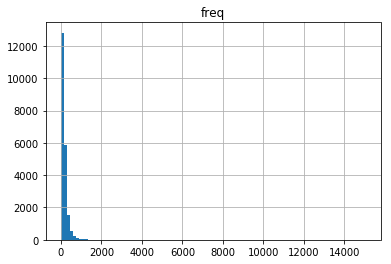

In [24]:
unique_genes.hist(bins=100, figsize=(6,4))

All genes	 21322
  min gene frequency 1
  max gene frequency 15036
  avg gene frequency 123

Targeted genes	 1079
  min gene frequency 401
  max gene frequency 699
  avg gene frequency 494


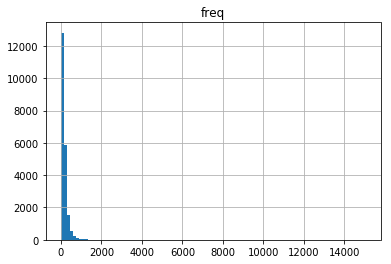

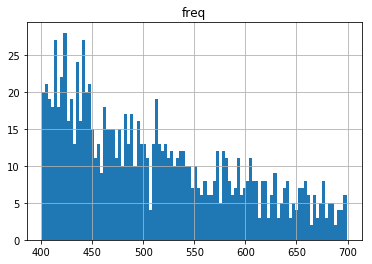

In [26]:
# Get a list of the unique gene names
unique_genes = mutations.groupby('Hugo_Symbol').count()[mutations.columns[0:1]]
unique_genes.columns = ['freq']

print('All genes\t', len(unique_genes))
print('  min gene frequency', unique_genes.min()[0])
print('  max gene frequency', unique_genes.max()[0])
print('  avg gene frequency', int(unique_genes.median()[0]))
unique_genes.hist(bins=100, figsize=(6,4))

feature_genes = unique_genes[(unique_genes.freq > 400) & (unique_genes.freq < 700)]
#feature_genes = feature_genes[unique_genes.freq > 400]
print('\nTargeted genes\t', len(feature_genes))
print('  min gene frequency', feature_genes.min()[0])
print('  max gene frequency', feature_genes.max()[0])
print('  avg gene frequency', int(feature_genes.median()[0]))
feature_genes.hist(bins=100, figsize=(6,4))

feature_genes = pd.DataFrame(feature_genes.index)

In [27]:
# We need to get a list of unique genes for every case
cases = list()
grouped = mutations.groupby('bcr_patient_barcode')
i = int(0)

cols = ['case', 'cancer_type', 'gender', 'age_at_diag']
for gene in feature_genes.Hugo_Symbol:
    cols.append(gene)


for name, group in grouped:
    case = list()
    case.append(name)
    for cc in group.cancer_type.head(1):
        case.append(cc)
    for gender in group.gender.head(1):
        case.append(gender)
    for diag_age in group.age_at_initial_pathologic_diagnosis.head(1):
        case.append(diag_age)
    for gene_flag  in feature_genes.Hugo_Symbol.isin(group.Hugo_Symbol.unique()):
        switch = 0
        if gene_flag == True:
            switch = 1
        case.append(switch)
    cases.append(case)
 

cases_df = pd.DataFrame(cases)
cases_df.columns = cols
print("Number of rows in full dataset", cases_df.case.count())


Number of rows in full dataset 10008


In [28]:
cases_df

,case,cancer_type,gender,age_at_diag,A2M,A2ML1,ABCA1,ABCA10,ABCA2,ABCA3,...,ZNF521,ZNF560,ZNF638,ZNF646,ZNF676,ZNF716,ZNF835,ZNF91,ZNFX1,ZZEF1
0,TCGA-02-0003,GBM,MALE,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-02-0033,GBM,MALE,54,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-02-0047,GBM,MALE,78,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-02-0055,GBM,FEMALE,62,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-02-2466,GBM,MALE,61,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,TCGA-02-2470,GBM,MALE,57,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,TCGA-02-2483,GBM,MALE,43,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,TCGA-02-2485,GBM,MALE,53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,TCGA-02-2486,GBM,MALE,64,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,TCGA-04-1331,OV,FEMALE,78,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Write out transformed data to csv
print("Writing case feature matrix to csv ...")
cases_df.to_csv("pancancer_case_features.csv")
print("done.")

Writing case feature matrix to csv ...
done.
